## **PROYEK PERTAMA BELAJAR PENGEMBANGAN MACHINE LEARNING**
## **Membuat Model NLP dengan TensorFlow**
#Nama : Addina Dwi Nugroho
#Email : addin27nugroho@gmail.com

In [17]:
#sambung google colab ke google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#baca dataset
import pandas as pd
df = pd.read_csv("/content/drive/My Drive/dataset/Womens Clothing E-Commerce Reviews.csv")

In [19]:
#lihat info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [20]:
#tampilkan 5 dataset teratas
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [21]:
df = df[['Review Text','Department Name']] #karena kita hanya membutuhkan kolom 'Review Text' dan 'Department Name', maka kita bisa hapus kolom yang lain

In [22]:
df.dropna(axis=0, inplace=True) #hapus data yang memiliki null value

In [23]:
df.info() #lihat kembali info dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22628 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Review Text      22628 non-null  object
 1   Department Name  22628 non-null  object
dtypes: object(2)
memory usage: 530.3+ KB


In [24]:
df.head() #lihat kembali dataset teratas

,Review Text,Department Name
0,Absolutely wonderful - silky and sexy and comf...,Intimate
1,Love this dress! it's sooo pretty. i happene...,Dresses
2,I had such high hopes for this dress and reall...,Dresses
3,"I love, love, love this jumpsuit. it's fun, fl...",Bottoms
4,This shirt is very flattering to all due to th...,Tops


In [25]:
#Karena label berupa data kategorikal, maka perlu dilakukan proses one-hot-encoding
category = pd.get_dummies(df['Department Name'])
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='Department Name')
df_baru

,Review Text,Bottoms,Dresses,Intimate,Jackets,Tops,Trend
0,Absolutely wonderful - silky and sexy and comf...,0,0,1,0,0,0
1,Love this dress! it's sooo pretty. i happene...,0,1,0,0,0,0
2,I had such high hopes for this dress and reall...,0,1,0,0,0,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1,0,0,0,0,0
4,This shirt is very flattering to all due to th...,0,0,0,0,1,0
...,...,...,...,...,...,...,...
23481,I was very happy to snag this dress at such a ...,0,1,0,0,0,0
23482,"It reminds me of maternity clothes. soft, stre...",0,0,0,0,1,0
23483,"This fit well, but the top was very see throug...",0,1,0,0,0,0
23484,I bought this dress for a wedding i have this ...,0,1,0,0,0,0


In [26]:
#ubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values agar dapat diproses oleh model
review = df_baru['Review Text'].values
label = df_baru[['Intimate', 'Dresses', 'Bottoms', 'Tops', 'Jackets', 'Trend']].values

In [27]:
#bagi data untuk training dan untuk testing
from sklearn.model_selection import train_test_split
review_latih, review_test, label_latih, label_test = train_test_split(review, label, test_size=0.2)

In [28]:
#ubah setiap kata pada dataset ke dalam bilangan numerik dengan fungsi Tokenizer, kemudian konversikan setiap sampel menjadi sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
 
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(review_latih) 
tokenizer.fit_on_texts(review_test)
 
sekuens_latih = tokenizer.texts_to_sequences(review_latih)
sekuens_test = tokenizer.texts_to_sequences(review_test)
 
padded_latih = pad_sequences(sekuens_latih) 
padded_test = pad_sequences(sekuens_test)

In [29]:
#latih data dengan model sequential sesuai kriteria submission
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
#Gunakan Callback agar proses otomatis berhenti ketika akurasi model memenuhi kriteria (81%)
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.81):
      print("\nAKURASI MODEL LEBIH DARI 81%! PELATIHAN MODEL DIHENTIKAN.")
      self.model.stop_training = True

callbacks = myCallback()

In [31]:
#latih model dengan model.fit
num_epochs = 30
history = model.fit(padded_latih, label_latih, epochs=num_epochs, 
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[callbacks])

Epoch 1/30
566/566 - 40s - loss: 1.2947 - accuracy: 0.5160 - val_loss: 1.0384 - val_accuracy: 0.6513
Epoch 2/30
566/566 - 37s - loss: 0.9707 - accuracy: 0.6962 - val_loss: 0.9113 - val_accuracy: 0.7227
Epoch 3/30
566/566 - 37s - loss: 0.7278 - accuracy: 0.7908 - val_loss: 0.7121 - val_accuracy: 0.8023
Epoch 4/30
566/566 - 37s - loss: 0.6664 - accuracy: 0.8091 - val_loss: 0.6571 - val_accuracy: 0.8060
Epoch 5/30
566/566 - 37s - loss: 0.5872 - accuracy: 0.8250 - val_loss: 0.7109 - val_accuracy: 0.8056
Epoch 6/30
566/566 - 37s - loss: 0.6906 - accuracy: 0.7962 - val_loss: 0.8581 - val_accuracy: 0.7680
Epoch 7/30
566/566 - 38s - loss: 0.6374 - accuracy: 0.8118 - val_loss: 0.7556 - val_accuracy: 0.7596
Epoch 8/30
566/566 - 37s - loss: 0.5420 - accuracy: 0.8356 - val_loss: 0.6759 - val_accuracy: 0.8062
Epoch 9/30
566/566 - 38s - loss: 0.5062 - accuracy: 0.8468 - val_loss: 0.6712 - val_accuracy: 0.7950
Epoch 10/30
566/566 - 37s - loss: 0.4810 - accuracy: 0.8554 - val_loss: 0.7282 - val_accura

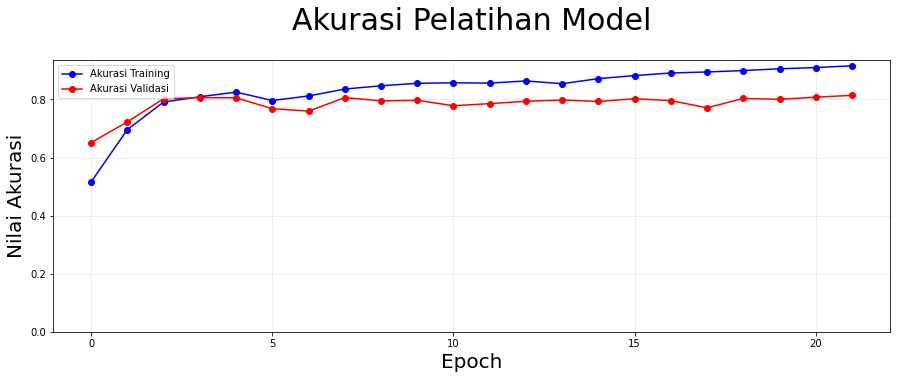

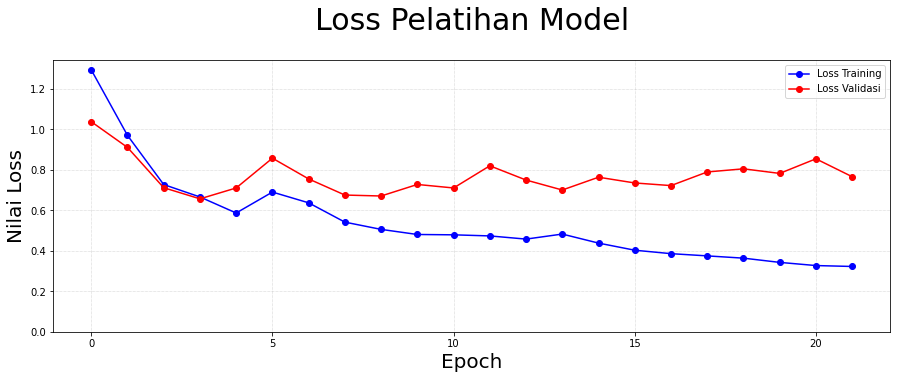

In [32]:
#visualisasi hasil pelatihan model
import matplotlib.pyplot as plt #import library untuk visualisasi data

train_acc = history.history['accuracy'] #akurasi training
val_acc = history.history['val_accuracy'] #akurasi validation
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_acc)) #jumlah epoch

plt.figure(figsize=(15,5))
plt.plot(epochs, train_acc, marker='o', color='blue', label='Akurasi Training')
plt.plot(epochs, val_acc, marker='o', color='red', label='Akurasi Validasi')
plt.legend()
plt.title('Akurasi Pelatihan Model', pad=30, fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Nilai Akurasi', fontsize=20)
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.xticks([0,5,10,15,20])
plt.ylim(ymin=0)
plt.show()

plt.figure(figsize=(15,5))
plt.plot(epochs, train_loss, marker='o', color='blue', label='Loss Training')
plt.plot(epochs, val_loss, marker='o', color='red', label='Loss Validasi')
plt.legend()
plt.title('Loss Pelatihan Model', pad=30, fontsize=30)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Nilai Loss', fontsize=20)
plt.grid(color='darkgray', linestyle=':', linewidth=0.5)
plt.xticks([0,5,10,15,20])
plt.ylim(ymin=0)
plt.show()